# Comparing Supervised Learning and RL Using Stock Data

(Insert explanation of our process here)

## Supervised Learning Approach

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import CSVLogger
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
import os

TIME_STEPS = 50
BATCH_SIZE = 50


Using TensorFlow backend.


### Reading Stock Data

In [2]:
msft = pd.read_csv("./Individual_Stock_Data/MSFT.csv")

In [3]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


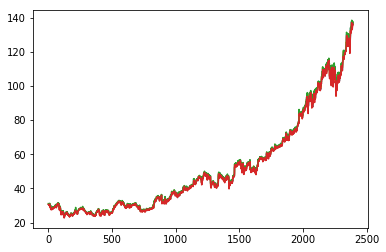

In [4]:
plt.figure()
plt.plot(msft["Open"])
plt.plot(msft["Close"])
plt.plot(msft["High"])
plt.plot(msft["Low"])
plt.show()

### Normalize Data

In [5]:
df_train, df_test = train_test_split(msft, train_size=0.8, test_size=0.2, shuffle=False)

In [6]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


In [7]:
df_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1913,2017-08-09,72.25,72.51,72.05,72.47,69.95,22213400
1914,2017-08-10,71.90,72.19,71.35,71.41,68.92,24734500
1915,2017-08-11,71.61,72.70,71.28,72.50,69.98,21443700
1916,2017-08-14,73.06,73.72,72.95,73.59,71.03,20096600
1917,2017-08-15,73.59,73.59,73.04,73.22,71.05,19181400


In [8]:
train_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
print("Train and Test Size:", len(df_train), len(df_test))
x = df_train.drop(columns=["Date"]).values
min_max_scaler = MinMaxScaler()

# Transforming Data
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.fit_transform(df_test.drop(columns=["Date"]).values)

Train and Test Size: 1913 479


In [9]:
x_train.shape, x_test.shape

((1913, 6), (479, 6))

## Build Time-Series Structure

In [10]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0, dim_1 = mat.shape[0] - TIME_STEPS, mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (1863, 50, 6) (1863,)
length of time-series i/o (429, 50, 6) (429,)


In [11]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

W1112 15:32:26.622848 26092 deprecation_wrapper.py:119] From C:\Users\adebi\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1112 15:32:26.659987 26092 deprecation_wrapper.py:119] From C:\Users\adebi\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1112 15:32:26.673714 26092 deprecation_wrapper.py:119] From C:\Users\adebi\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1112 15:32:26.962274 26092 deprecation_wrapper.py:119] From C:\Users\adebi\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1112 15:32:26.971915 26092 deprecation.py:506

In [12]:
csv_logger = CSVLogger("stock_supervised.log", append=True)

history = lstm_model.fit(x_t, y_t, epochs=50, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])
print(history)


W1112 15:32:27.364294 26092 deprecation.py:323] From C:\Users\adebi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1112 15:32:27.819785 26092 deprecation_wrapper.py:119] From C:\Users\adebi\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1850 samples, validate on 200 samples
Epoch 1/50
 - 3s - loss: 0.0234 - val_loss: 0.2496
Epoch 2/50
 - 1s - loss: 0.0515 - val_loss: 0.1052
Epoch 3/50
 - 1s - loss: 0.0109 - val_loss: 0.0571
Epoch 4/50
 - 1s - loss: 0.0070 - val_loss: 0.0293
Epoch 5/50
 - 1s - loss: 0.0060 - val_loss: 0.0152
Epoch 6/50
 - 1s - loss: 0.0053 - val_loss: 0.0109
Epoch 7/50
 - 1s - loss: 0.0043 - val_loss: 0.0066
Epoch 8/50
 - 1s - loss: 0.0041 - val_loss: 0.0083
Epoch 9/50
 - 1s - loss: 0.0036 - val_loss: 0.0049
Epoch 10/50
 - 1s - loss: 0.0031 - val_loss: 0.0037
Epoch 11/50
 - 1s - loss: 0.0026 - val_loss: 0.0025
Epoch 12/50
 - 1s - loss: 0.0025 - val_loss: 0.0035
Epoch 13/50
 - 1s - loss: 0.0023 - val_loss: 0.0020
Epoch 14/50
 - 1s - loss: 0.0028 - val_loss: 0.0033
Epoch 15/50
 - 1s - loss: 0.0022 - val_loss: 0.0017
Epoch 16/50
 - 1s - loss: 0.0025 - val_loss: 0.0028
Epoch 17/50
 - 1s - loss: 0.0023 - val_loss: 0.0019
Epoch 18/50
 - 1s - loss: 0.0023 - val_loss: 0.0017
Epoch 19/50
 - 1s - loss: 

In [13]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

Error is 0.004571873817022034 (200,) (200,)
[0.61022204 0.6246482  0.6398614  0.6543728  0.6587168  0.6582845
 0.6612307  0.6501589  0.6455996  0.64162034 0.63716316 0.62710035
 0.62392926 0.6275127  0.6355957 ]
[0.5645623  0.5737532  0.57646527 0.56637035 0.55446738 0.5748079
 0.5461805  0.54587916 0.54497514 0.53427754 0.52086786 0.53714027
 0.5446738  0.55733012 0.57541058]


<Figure size 432x288 with 0 Axes>

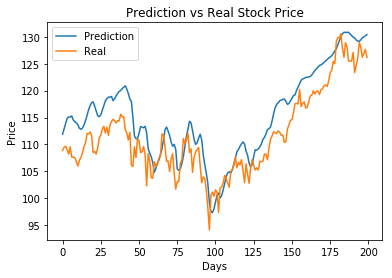

<Figure size 432x288 with 0 Axes>

In [14]:
from matplotlib import pyplot as plt
plt.figure()
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# #plt.show()
# plt.savefig( 'train_vis_BS_.png')

from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
plt.savefig('pred_vs_real_BS_.png')


## Reinforcement Learning Approach (Q-Learning)

### Create Environment for ML Agent

In [23]:
class Environment:
    def __init__(self, data, h_t=90):
        self.data = data
        self.h_t = h_t
        self.reset()
    
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0 
        self.positions = [] # list of current stocks with the trading bot
        self.position_val = 0
        self.history = [0 for _ in range(self.h_t)]
        return [self.position_val] + self.history
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [24]:
env = Environment(df_train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print (pact)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.010000000000001563], -1, False)
1
([-0.19000000000000128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.010000000000001563, -0.19000000000000128], 0, False)
2
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [25]:
class Q_Network:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()     
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
        

NameError: name 'nn' is not defined